In [1]:
# Importing necessary libraries for the analysis.
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
#import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import csv
import math

In [2]:
from utils import *
from autoencoder import Autoencoder
from diffusion_networks import *
from sampler import edm_sampler

In [12]:
# Defining the constants and configurations used throughout the notebook.
iterations = 2101000 # 101000
on_remote = False
data_path = Path(f'/nobackup/smhid20/users/sm_maran/dpr_data/simulations/QG_samples_SUBS_{iterations}.npy') if on_remote else Path(f'C:/Users/svart/Desktop/MEX/data/QG_samples_SUBS_{iterations}.npy')
k = 50
spinup = 1001
spacing = 10
p_train = 0.8
mean_data = 0.003394413273781538
std_data = 9.174626350402832

batch_size = 128 # 256 Largest possible batch size that fits on the GPU w.f32

date = '2024-02-21'
autoencoder_model = 'ae-2ds-32f-1l-150e-L1-0wd-0.00001l1' #'ae-3ds-16f-2l-150e-L1-0wd-0.00001l1'# 

autoencoder_path = Path(f'/nobackup/smhid20/users/sm_maran/results/{date}/{autoencoder_model}/') if on_remote else Path(f'C:/Users/svart/Desktop/MEX/results/{date}/{autoencoder_model}/')

#ae-2ds-32f-1l-150e-L1-0wd-0.00001l1
mean_data_latent = -0.6132266521453857 # -0.6324582099914551
std_data_latent = 5.066834926605225 # 5.280972003936768
std_residual_latent =5.375336170196533# 5.724194526672363
 
#ae-3ds-16f-2l-150e-L1-0wd-0.00001l1
#mean_data_latent = -1.2714290618896484
#std_data_latent = 3.313279628753662

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [115]:

date = '2024-02-22'
result_model = 'forecast-32f-2ds-50k' #'ae-3ds-16f-2l-150e-L1-0wd-0.00001l1'# 

result_path = Path(f'/nobackup/smhid20/users/sm_maran/results/{date}/{result_model}/') if on_remote else Path(f'C:/Users/svart/Desktop/MEX/results/{date}/{result_model}/')

import json
# FILEPATH: /c:/Users/svart/Desktop/MEX/QG-Forecasting/Diffusion.ipynb
# Load the saved model
saved_model = torch.load(result_path / 'best_model.pth')

# Read parameters from JSON file
with open(result_path / 'config.json', 'r') as json_file:
    parameters = json.load(json_file)

# Extract the desired parameters
filters = parameters['filters']
no_downsamples = parameters['no_downsamples']
model_name = parameters['model']
k = parameters['k']

if model_name == "generate":
        forecasting = False
        model = GCPrecond(sigma_data=1, filters=filters, no_downsamples=no_downsamples, img_channels=1, img_resolution = 16)
    
elif model_name == "forecast":
    forecasting = True
    model = GCPrecond(sigma_data=1, filters=filters, no_downsamples=no_downsamples, img_channels=2, img_resolution = 16)
   
# Load the state_dict of the saved model into the conv_autoencoder
model.load_state_dict(saved_model)

model.to(device)
model.eval()

print("Model loaded successfully!")

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\svart\\Desktop\\MEX\\results\\2024-02-22\\forecast-32f-2ds-50k\\best_model.pth'

# Data Loading

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataset = QGSamplesDataset(data_path, 'train', p_train, k, spinup, spacing, iterations, mean_data, std_data, device)
val_dataset = QGSamplesDataset(data_path, 'val', p_train, k, spinup, spacing, iterations, mean_data, std_data, device)
#test_dataset = QGSamplesDataset(data_path, 'test', p_train, k, spinup, spacing, iterations, mean_data, std_data, device)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
#test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Autoencoder

In [5]:
import json
# FILEPATH: /c:/Users/svart/Desktop/MEX/QG-Forecasting/Diffusion.ipynb
# Load the saved model
saved_model = torch.load(autoencoder_path / 'best_model.pth')

# Read parameters from JSON file
with open(autoencoder_path / 'config.json', 'r') as json_file:
    parameters = json.load(json_file)

# Extract the desired parameters
filters = parameters['filters']
latent_dim = parameters['latent_dim']
no_downsamples = parameters['no_downsamples']

# Create an instance of the ConvolutionalAutoencoder class
autoencoder = Autoencoder(filters= filters, no_latent_channels=latent_dim, no_downsamples=no_downsamples)

# Load the state_dict of the saved model into the conv_autoencoder
autoencoder.load_state_dict(saved_model)

autoencoder.to(device)
autoencoder.eval()

print("Autoencoder loaded successfully!")

Autoencoder loaded successfully!


In [21]:
def calculate_latent_mean_std():
    # Calculate mean and var
    # Initialize variables for mean and standard deviation
    mean_data_latent = 0.0
    std_data_latent = 0.0
    count = 0
    #autoencoder.to('cpu')
    # Iterate over the batches in train_loader
    autoencoder.eval()
    with torch.no_grad():
        for current, next in train_loader:
            # Get the input data from the batch
            latent = autoencoder.encoder(current)
            next_latent = autoencoder.encoder(next)
            
            inputs = next_latent -  latent

            count += inputs.size(0)

            # Calculate the sum of the input data
            mean_data_latent += torch.sum(inputs)
            std_data_latent += torch.sum(inputs ** 2)
            #print(mean_data_latent/count, std_data_latent/count, count)
            
        # Calculate the mean and standard deviation
        count = count * inputs[0].cpu().detach().numpy().size
        # TODO
        mean_data_latent /= count
        std_data_latent = torch.sqrt(std_data_latent / count - mean_data_latent ** 2)

        # Print the mean and standard deviation
        print("Mean:", mean_data_latent.item())
        print("Standard Deviation:", std_data_latent.item())

    return mean_data_latent, std_data_latent

calculate_latent_mean_std()
print(mean_data_latent, std_data_latent, std_residual_latent)

Mean: -6.831114205851918e-06
Standard Deviation: 5.375336170196533
-0.03832172974944115 1.3086596727371216 6.599302768707275


# Diffusion

### Sampling

In [6]:
def sample_and_plot(net, class_labels = None, img_channels=1):
    sampler_fn = edm_sampler
    
    latents = torch.randn([1, img_channels, net.img_resolution, net.img_resolution], device=device)
    image, images  = sampler_fn(net, latents, class_labels, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=70, S_noise=1.05)

    # TODO Fix such that you can plot smaller resolutions
    plt.figure(figsize=(images.shape[0], 1))
    plt.tight_layout()
    for i in range(images.shape[0]):
        plt.subplot(1, images.shape[0], i+1)
        plt.imshow(images[i,0, 0].cpu().detach().numpy())
        plt.axis('off')
    plt.show()
    
sample_and_plot(model, img_channels=2)

NameError: name 'model' is not defined

In [7]:
def sample_and_plot_with_truth(net, class_labels = None, truth = None):
    sampler_fn = edm_sampler
    
    latents = torch.randn([1, 1, net.img_resolution, net.img_resolution], device=device)
    image, images  = sampler_fn(net, latents, class_labels, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=70, S_noise=1.05)

    if class_labels is not None:
        images = torch.cat([truth.unsqueeze(0), images], dim=0)
    
    plt.figure(figsize=(images.shape[0], 1))
    plt.tight_layout()
    for i in range(images.shape[0]):
        plt.subplot(1, images.shape[0], i+1)
        plt.imshow(images[i,0, 0].cpu().detach().numpy())
        plt.axis('off')
    plt.show()

for previous, current in train_loader:
    with torch.no_grad():
        current_latent = autoencoder.encoder(current)
        current_latent = (current_latent - mean_data_latent) / std_data_latent

        previous_latent = autoencoder.encoder(previous)
        previous_latent = (previous_latent - mean_data_latent) / std_data_latent

    current_latent = current_latent[0].unsqueeze(0)
    previous_latent = previous_latent[0].unsqueeze(0)
    break
sample_and_plot_with_truth(model, class_labels = previous_latent, truth = current_latent)

NameError: name 'model' is not defined

In [7]:
def plot_forecasts_from_residual(model, num_images=4):
    for previous, current in train_loader:
        with torch.no_grad():
            
            #current_latent = autoencoder.encoder(current)
            previous_latent = autoencoder.encoder(previous)
            
            #residual_latent = (current_latent - previous_latent) / std_residual_latent
        
        #residual_latent = residual_latent[0].unsqueeze(0)
        previous_latent = previous_latent[0].unsqueeze(0)
        break

    img_channels = previous_latent.size(1)
    class_labels = previous_latent.repeat(num_images, 1, 1, 1)

    sampler_fn = edm_sampler
    latents = torch.randn([num_images, img_channels, model.img_resolution, model.img_resolution], device=device)

    
    residuals, _  = sampler_fn(model, latents, class_labels, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=70, S_noise=1.05)

    predicted_latent = previous_latent + residuals * std_residual_latent

    predicted = autoencoder.decoder(predicted_latent.to(torch.float32)).cpu().detach().numpy()[:,0]
    previous = previous[0,0].cpu().detach().numpy()
    current = current[0,0].cpu().detach().numpy()

    vmin = min(predicted.min(), current.min(), previous.min())
    vmax = max(predicted.max(), current.max(), previous.max())

    fig, axes = plt.subplots(1, 2+num_images, figsize=(15, 5))

    axes[0].imshow(previous, vmin=vmin, vmax=vmax)
    axes[0].axis('off')
    axes[0].set_title('Previous')

    axes[1].imshow(current, vmin=vmin, vmax=vmax)
    axes[1].axis('off')
    axes[1].set_title('Truth')

    for i in range(num_images):
        axes[i+2].imshow(predicted[i], vmin=vmin, vmax=vmax)
        axes[i+2].axis('off')
        axes[i+2].set_title('Sampled')

    plt.tight_layout()
    plt.show()

plot_forecasts_from_residual(model)

NameError: name 'model' is not defined

In [8]:
def sample_and_upsample(net, class_labels = None, img_channels=1, num_images=16):
    sampler_fn = edm_sampler
    
    latents = torch.randn([num_images, img_channels, net.img_resolution, net.img_resolution], device=device)
    images, _  = sampler_fn(net, latents, class_labels, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=70, S_noise=1.05)

    images = images * std_data_latent + mean_data_latent
    images = autoencoder.decoder(images.to(torch.float32)).cpu().detach().numpy()

    sqrt_num_images = int(np.ceil(math.sqrt(num_images)))

    fig, axes = plt.subplots(sqrt_num_images, sqrt_num_images, figsize=(16,16))

    for i in range(images.shape[0]):
        axes[i // sqrt_num_images, i % sqrt_num_images].imshow(images[i,0])
        axes[i // sqrt_num_images, i % sqrt_num_images].axis('off')
        plt.tight_layout()  


    plt.show()
sample_and_upsample(model)

NameError: name 'model' is not defined

In [ ]:
def plot_real_images(net, class_labels = None, img_channels=1, num_images=16):
    
    for previous, current in train_loader:
        images = current[:num_images]
        break
    sqrt_num_images = int(np.ceil(math.sqrt(num_images)))

    fig, axes = plt.subplots(sqrt_num_images, sqrt_num_images, figsize=(16,16))

    for i in range(images.shape[0]):
        axes[i // sqrt_num_images, i % sqrt_num_images].imshow(images[i,0])
        axes[i // sqrt_num_images, i % sqrt_num_images].axis('off')
        plt.tight_layout()  


    plt.show()
plot_real_images(model)

### Training

In [7]:
#from prediff.models.cuboid_transformer import CuboidTransformerUNet
#import warnings

ImportError: cannot import name 'CuboidTransformerUNet' from 'earthformer.cuboid_transformer' (c:\Users\svart\Desktop\MEX\QG-Forecasting\earthformer\cuboid_transformer\__init__.py)

In [6]:
class GCPrecond(torch.nn.Module):
    def __init__(self, sigma_data=1, sigma_min=0.02, sigma_max=88, filters=128, no_downsamples=2, img_channels=1, img_resolution = 65, time_emb_dim=16, isLatent=True):
        super(GCPrecond, self).__init__()
        self.sigma_data = sigma_data
        self.sigma_min = sigma_min
        self.sigma_max = sigma_max
        
        self.img_resolution = img_resolution
        self.img_channels = img_channels

        #'ddpmpp':
        #self.model = SongUNet(img_resolution=img_resolution, in_channels=img_channels, out_channels=1, \
        #                      embedding_type='positional', encoder_type='standard', decoder_type='standard', \
        #                      channel_mult_noise=1, resample_filter=[1,1], model_channels=filters, channel_mult=[2,2,2],
        #                      num_blocks=4, )
        
        #'ncsnpp':
        self.model = SongUNet(img_resolution=img_resolution, in_channels=img_channels, out_channels=1, \
                              embedding_type='fourier', encoder_type='residual', decoder_type='standard', \
                              channel_mult_noise=2, resample_filter=[1,3,3,1], model_channels=filters, channel_mult=[2,2,2])

    
        #self.model = SimpleUnet(filters=filters, no_downsamples=no_downsamples, image_channels=self.img_channels, time_emb_dim=time_emb_dim, isLatent=isLatent)
        #self.model = DhariwalUNet(img_resolution=img_resolution, in_channels=img_channels, out_channels=1, model_channels=192, channel_mult=[1,2,3,4])
        #self.model = CuboidTransformerUNet(input_shape=(img_channels, img_resolution, img_resolution, batch_size), target_shape=(1, img_resolution, img_resolution, batch_size))
        
    def forward(self, x, sigma, class_labels=None):
        dtype = torch.float32
        x = x.to(dtype) # EMA does this
        sigma = sigma.to(dtype).reshape(-1, 1, 1, 1) # EMA does this

        # Change these if we want
        c_skip = self.sigma_data ** 2 / (sigma **2 + self.sigma_data ** 2)
        c_out = sigma * self.sigma_data / (sigma ** 2+ self.sigma_data ** 2).sqrt()
        c_in = 1 / (self.sigma_data ** 2 + sigma ** 2).sqrt()
        c_noise = sigma.log() / 4

        F_x = self.model((c_in * x).to(dtype), c_noise.flatten(), class_labels)
        assert F_x.dtype == dtype
        D_x = c_skip * x + c_out * F_x.to(dtype)
        
        return D_x

    def round_sigma(self, sigma):
        return torch.as_tensor(sigma)

In [14]:
forecasting = True

num_epochs = 200

model = GCPrecond(filters=32, img_channels=2 if forecasting else 1, img_resolution = 16)
print("Num params: ", sum(p.numel() for p in model.parameters()))

model.to(device)
 
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.1)
#optim.Adam(model.parameters(), lr=0.00001, weight_decay=0.001)
loss_fn = GCLoss()

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
warmup_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=0.001, end_factor=1.0, total_iters=1000)
loss_values = []
val_loss_values = []
best_val_loss = float('inf')

# Setup for logging
log_file_path = 'training_log.csv'
with open(log_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the header
    writer.writerow(['Epoch', 'Average Training Loss', 'Validation Loss'])

Num params:  3541473


In [23]:
# Both Generation and Forecasting

import time
from tqdm import tqdm

# Training loop

log_interval = 100#len(train_loader) // 4

for epoch in range(num_epochs):
    start_time = time.time()

    model.train()  # Set model to training mode
    total_train_loss = 0

    current_loss = 0
    count = 0

    for previous, current in tqdm(train_loader):
        count += 1
        optimizer.zero_grad()

        with torch.no_grad():
            current_latent = autoencoder.encoder(current)
            previous_latent = None

            if forecasting:
                previous_latent = autoencoder.encoder(previous)
                target_latent = (current_latent - previous_latent) / std_residual_latent
            else:
                target_latent = (current_latent - mean_data_latent) / std_data_latent
            
        loss = loss_fn(model, target_latent, previous_latent)

        total_train_loss += loss.item()
        current_loss += loss.item()

        loss.backward()
        optimizer.step()

        if count % log_interval == 0:
            # Calculate and log the current average loss
            current_loss = current_loss / count

            print(f'Average Loss: {current_loss:.4f}')

            current_loss = 0
            count = 0
        
        #warmup_scheduler.step()

            
    
    avg_train_loss = total_train_loss / len(train_loader)
    
    train_time = time.time() - start_time
    start_time = time.time()

    # Validation phase
    model.eval()  # Set model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():
        for previous, current in tqdm(val_loader):
            current_latent = autoencoder.encoder(current)
            previous_latent = None

            if forecasting:
                previous_latent = autoencoder.encoder(previous)
                target_latent = (current_latent - previous_latent) / std_residual_latent
            else:
                target_latent = (current_latent - mean_data_latent) / std_data_latent
            
            loss = loss_fn(model, target_latent, previous_latent)
            
            total_val_loss += loss.item()
            
    avg_val_loss = total_val_loss / len(val_loader)

    # Checkpointing
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    val_time = time.time() - start_time
    start_time = time.time()
    
    scheduler.step()
        
    if forecasting:
        #plot_ensemble(model)
        #plot_forecasts_from_residual(model)
        pass
    else:
        pass
        #sample_and_plot(model, img_channels=1)

    sample_time = time.time() - start_time
    
    # Log to CSV    
    loss_values.append([avg_train_loss])
    val_loss_values.append(avg_val_loss)  # Assuming val_loss_values list exists
    
    # Log to CSV
    with open(log_file_path, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([epoch+1, avg_train_loss, avg_val_loss])
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
    print(f'Training time: {train_time:.5f}s, Validation time: {val_time:.5f}s, Sample time: {sample_time:.5f}s')
    torch.save(model.state_dict(), 'final_model.pth')


# Plotting
plt.figure(figsize=(10, 6))
loss_plot = np.array(loss_values)
plt.plot(loss_plot[1:], label='Training Loss', color='blue')

plt.plot(val_loss_values[1:], label='Validation Loss', color='red')
plt.title('Loss as a Function of Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.legend()
plt.show()

  8%|▊         | 100/1313 [00:38<08:23,  2.41it/s]

Average Loss: 46.0725


 15%|█▌        | 200/1313 [01:20<07:43,  2.40it/s]

Average Loss: 44.4240


 23%|██▎       | 300/1313 [02:01<07:02,  2.40it/s]

Average Loss: 43.6399


 30%|███       | 400/1313 [02:43<06:20,  2.40it/s]

Average Loss: 42.8372


 38%|███▊      | 500/1313 [03:24<05:36,  2.41it/s]

Average Loss: 43.7144


 46%|████▌     | 600/1313 [04:06<04:56,  2.40it/s]

Average Loss: 42.4855


 53%|█████▎    | 700/1313 [04:48<04:37,  2.21it/s]

Average Loss: 42.4293


 61%|██████    | 800/1313 [05:34<03:53,  2.19it/s]

Average Loss: 42.5596


 69%|██████▊   | 900/1313 [06:16<02:51,  2.40it/s]

Average Loss: 41.7862


 76%|███████▌  | 1000/1313 [06:57<02:09,  2.42it/s]

Average Loss: 41.9760


 80%|████████  | 1051/1313 [07:18<01:49,  2.40it/s]

### Evaluate Forecasts

C:\Users\svart\AppData\Local\Temp\ipykernel_22968\759846100.py:1: DeprecationWarning: Please use `uniform_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import uniform_filter1d


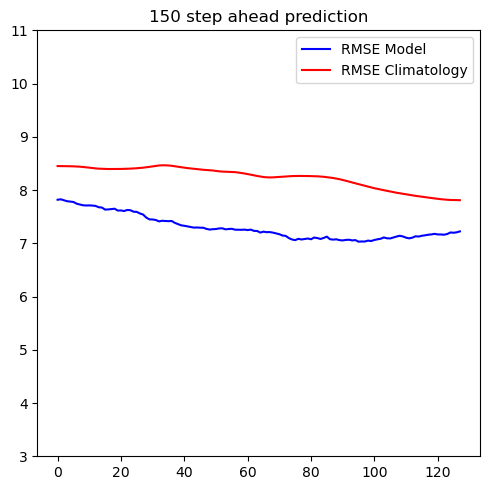

In [10]:
from scipy.ndimage.filters import uniform_filter1d
running_mean = 100

def generate_forecasts(model):
    model.eval()
    sampler_fn = edm_sampler

    num_images = 128
    num_images -= num_images%batch_size
    rmse_model_list = np.zeros(num_images)
    rmse_clim_list = np.zeros(num_images)

    count=0
    for previous, current in val_loader:
        with torch.no_grad():
            current_latent = autoencoder.encoder(current)
            previous_latent = autoencoder.encoder(previous)
            residual_latent = (current_latent - previous_latent) / std_residual_latent
            
            latents = torch.randn([residual_latent.size(0), residual_latent.size(1), model.img_resolution, model.img_resolution], device=device)
            class_labels = previous_latent

            predicted_residuals, _  = sampler_fn(model, latents, class_labels, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=70, S_noise=1.05)
            predicted_latent = previous_latent + predicted_residuals * std_residual_latent
            
            predicted = autoencoder.decoder(predicted_latent.to(torch.float32))

            predicted_unscaled = predicted * std_data + mean_data
            current_unscaled = current * std_data + mean_data
            previous_unscaled = previous * std_data + mean_data

            climatology = current_unscaled.mean(dim=0)

            rmse_model = ((predicted_unscaled - current_unscaled)**2).mean(dim=(1,2,3)).sqrt().cpu().detach().numpy()
            rmse_clim = ((climatology - current_unscaled)**2).mean(dim=(1,2,3)).sqrt().cpu().detach().numpy()

            rmse_model_list[count:count+rmse_model.size] = rmse_model
            rmse_clim_list[count:count+rmse_model.size] = rmse_clim

            count += rmse_model.size
        if count >= num_images:
            break
        
    return rmse_model_list, rmse_clim_list

rmse_model, rmse_clim = generate_forecasts(model)

plt.figure(figsize=(5,5))
plt.title(f'{k} step ahead prediction')
plt.plot(uniform_filter1d(rmse_model, size=running_mean), label='RMSE Model', color='b')
plt.plot(uniform_filter1d(rmse_clim, size=running_mean), label='RMSE Climatology', color='r')
plt.ylim(3,11)
plt.legend()
plt.tight_layout()
plt.show()

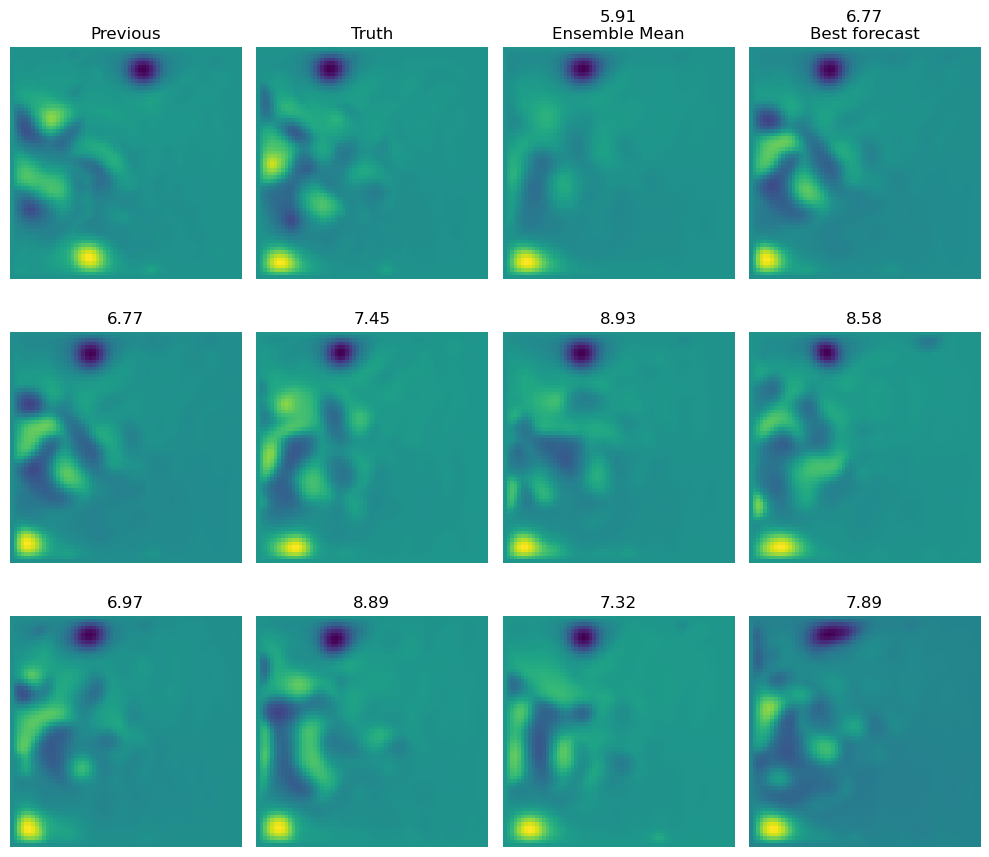

In [11]:
def plot_ensemble(model):
    model.eval()
    sampler_fn = edm_sampler

    n_ens = 10
    for previous, current in val_loader:
        with torch.no_grad():
            batch_size = current.size(0)

            current_latent = autoencoder.encoder(current)
            previous_latent = autoencoder.encoder(previous)
            residual_latent = (current_latent - previous_latent) / std_residual_latent
            
            for i in range(batch_size):
                latents = torch.randn([n_ens, residual_latent.size(1), model.img_resolution, model.img_resolution], device=device)
                class_labels = previous_latent[i].repeat(n_ens, 1, 1, 1)

                predicted_residuals, _  = sampler_fn(model, latents, class_labels, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=70, S_noise=1.05)
                predicted_latent = class_labels + predicted_residuals * std_residual_latent
                
                predicted = autoencoder.decoder(predicted_latent.to(torch.float32))

                predicted_unscaled = predicted * std_data + mean_data
                current_unscaled = current[i] * std_data + mean_data
                previous_unscaled = previous[i] * std_data + mean_data
                break

        break

    ensemble_mean = predicted_unscaled.mean(dim=0)
    ensemble_rmse = ((ensemble_mean - current_unscaled)**2).mean(dim=(1,2)).sqrt().cpu().detach().numpy()[0]

    ensemble_rmses = ((predicted_unscaled - current_unscaled)**2).mean(dim=(2,3)).sqrt().cpu().detach().numpy().flatten()
    best_forecast = predicted_unscaled[np.argmin(ensemble_rmses)]
    best_rmse = ensemble_rmses[np.argmin(ensemble_rmses)]

    current_unscaled = current_unscaled.cpu().detach().numpy()[0]
    previous_unscaled = previous_unscaled.cpu().detach().numpy()[0]
    best_forecast = best_forecast.cpu().detach().numpy()[0]
    ensemble_mean = ensemble_mean.cpu().detach().numpy()[0]

    no_ens_rows = 2
    fig, axes = plt.subplots(1+no_ens_rows, 4, figsize=(10, 10))

    axes[0,0].imshow(previous_unscaled)
    axes[0,0].set_title("Previous")
    axes[0,0].axis('off')

    axes[0,1].imshow(current_unscaled)
    axes[0,1].set_title("Truth")
    axes[0,1].axis('off')

    axes[0,2].imshow(ensemble_mean)
    axes[0,2].set_title(f"{ensemble_rmse:.2f}\nEnsemble Mean")
    axes[0,2].axis('off')

    axes[0,3].imshow(best_forecast)
    axes[0,3].set_title(f"{best_rmse:.2f}\nBest forecast")
    axes[0,3].axis('off')

    count = 0
    for i in range(no_ens_rows):
        for j in range(4):
            axes[1+i,j].imshow(predicted_unscaled[count].cpu().detach().numpy()[0])
            axes[1+i,j].set_title(f"{ensemble_rmses[count]:.2f}")
            axes[1+i,j].axis('off')
            count+=1
        
            plt.tight_layout()
    
    plt.show()

plot_ensemble(model)


## Evaluation Pipeline

 What to do next
 \begin{itemize}
     \item Try other architectures
     \item Evaluation Pipeline
     \begin{itemize}
         \item CRPS
         \begin{itemize}
             \item Empirical and in limit
         \end{itemize}
         \item Brier Score
         \item Ensemble Mean RMSE
         \item Spread/Skill Ratio
         \item Rank Histogram
         \item Power Spectrum/Frequency domain
         \item FID?
         \begin{itemize}
             \item Create something similar from large dataset
         \end{itemize}
     \end{itemize}
     \item Compare variance of model with instability in NWP
     \begin{itemize}
         \item Simple measure such as trace of coovariance matrix
     \end{itemize}
 \end{itemize}


### Pipe

In [137]:
def generate_forecast(model, previous, n_ens=10, sampler_fn=edm_sampler):
    model.eval()
    
    previous = previous.unsqueeze(0)
    previous_latent = autoencoder.encoder(previous)
    
    latents = torch.randn([n_ens, model.img_channels//2, model.img_resolution, model.img_resolution], device=device)
    class_labels = previous_latent.repeat(n_ens, 1, 1, 1)

    predicted_residuals, _  = sampler_fn(model, latents, class_labels, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=70, S_noise=1.05)
    predicted_latent = class_labels + predicted_residuals * std_residual_latent
    
    predicted = autoencoder.decoder(predicted_latent.to(torch.float32))

    predicted_unscaled = predicted * std_data + mean_data

    return predicted_unscaled

In [425]:
def generate_forecasts(model, n_ens=10, selected_loader=val_loader, sampler_fn=edm_sampler):
    model.eval()

    for previous, current in selected_loader:
        with torch.no_grad():
            previous = previous[0]
            current_dp = current[0] * std_data + mean_data
            forecast = generate_forecast(model, previous, n_ens, sampler_fn)
            #forecast = autoencoder(current[0].unsqueeze(0))[0] * std_data + mean_data
            return forecast, current_dp

In [362]:
def calculate_skill_and_spread_score(forecast, truth):
    ens_mean = forecast.mean(dim=0)
    skill = ((ens_mean - truth)**2).mean().sqrt()
    
    N = forecast.size(0)
    spread = (((ens_mean - forecast)**2).sum(dim=0)/(N - 1)).mean().sqrt()

    ratio = np.sqrt((N+1)/N) * spread / skill
    return skill.item(), spread.item(), ratio.item()

In [361]:
def calculate_CRPS(forecast, truth):
    a = (forecast - truth).norm(dim=0, p=1)
    b = (forecast.unsqueeze(1) - forecast.unsqueeze(0)).abs().mean(dim=(0,1)) * 0.5
    return (a - b).mean().item()

In [37]:
def calculate_brier_score(forecast, truth, threshold=10):
    px = (forecast > threshold).to(torch.float32).mean(dim=0)
    py = (truth > threshold).to(torch.float32)
    
    brier = ((px - py)**2).mean()
    return brier.item()

In [38]:
forecast, truth = generate_forecasts(model, n_ens=100, selected_loader=val_loader, sampler_fn=edm_sampler)
skill, spread, ratio = calculate_skill_and_spread_score(forecast, truth)
crps = calculate_CRPS(forecast, truth)
brier = calculate_brier_score(forecast, truth, 20)

print(f"Skill: {skill:.2f}, Spread: {spread:.2f}, Ratio: {ratio:.3f}, CRPS: {crps:.0f}, Brier: {brier:.4f}")

TypeError: generate_forecasts() got an unexpected keyword argument 'n_ens'

In [383]:
def evaluation_pipeline(model, n_ens=10, selected_loader=val_loader, sampler_fn=edm_sampler):
    model.eval()

    results = {'skill': [], 'spread': [], 'ratio': [], 'crps': [], 'brier': []}
    for previous, current in selected_loader:
        for i in range(batch_size):
            with torch.no_grad():
                previous_datapoint = previous[i]
                current_datapoint = current[i] * std_data + mean_data
                forecast = generate_forecast(model, previous_datapoint, n_ens, sampler_fn)
                
                skill, spread, ratio = calculate_skill_and_spread_score(forecast, current_datapoint)
                crps = calculate_CRPS(forecast, current_datapoint)
                brier = calculate_brier_score(forecast, current_datapoint, 20)
                
                results['skill'].append(skill)
                results['spread'].append(spread)
                results['ratio'].append(ratio)
                results['crps'].append(crps)
                results['brier'].append(brier)

    return results

res = evaluation_pipeline(model, n_ens=10, selected_loader=val_loader, sampler_fn=edm_sampler)

KeyboardInterrupt: 

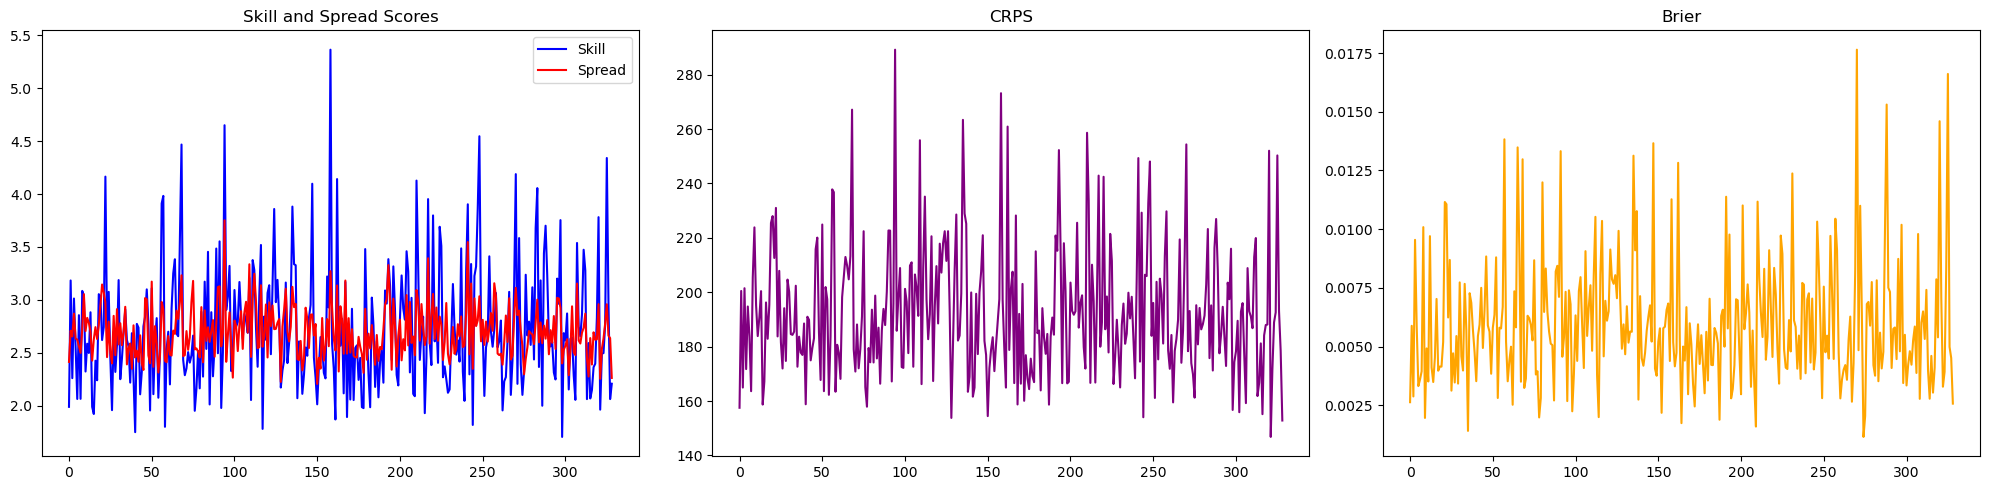

In [385]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

axes[0].plot(res['skill'], label='Skill', color='blue')
axes[0].set_title('Skill and Spread Scores')
axes[0].plot(res['spread'], label='Spread', color='red')
axes[0].legend()

#axes[2].plot(res['ratio'], label='Ratio', color='green')
#axes[2].set_title('Ratio')

axes[1].plot(res['crps'], label='CRPS', color='purple')
axes[1].set_title('CRPS')

axes[2].plot(res['brier'], label='Brier', color='orange')
axes[2].set_title('Brier')

plt.tight_layout()

plt.show()

In [382]:
torch.cov(forecast.view(forecast.size(0), -1)).trace()

tensor(8250.3447, device='cuda:0')

### Variance/ RMSE

In [8]:
#date = '2024-02-22'
#result_model = 'forecast-32f-2ds-50k' #'ae-3ds-16f-2l-150e-L1-0wd-0.00001l1'# 
#result_path = Path(f'/nobackup/smhid20/users/sm_maran/results/{date}/{result_model}/') if on_remote else Path(f'C:/Users/svart/Desktop/MEX/results/{date}/{result_model}/')

result_path = "best_model.pth"

# FILEPATH: /c:/Users/svart/Desktop/MEX/QG-Forecasting/Diffusion.ipynb
# Load the saved model
saved_model = torch.load(result_path)

model = GCPrecond(filters=64, img_channels=2, img_resolution = 16)
# Load the state_dict of the saved model into the conv_autoencoder
model.load_state_dict(saved_model)

model.to(device)
model.eval()

print("Model loaded successfully!")

Model loaded successfully!


In [27]:
from utils import NWPDataset

In [26]:
kmax = 100
iterations = 2101000
n_val = 210000
nwp_data_path = Path(f'/nobackup/smhid20/users/sm_maran/dpr_data/simulations/QG_samples_LRES_{iterations}_n_{n_val}_k_{kmax}.npy') if on_remote else Path(f'C:/Users/svart/Desktop/MEX/data/QG_samples_LRES_{iterations}_n_{n_val}_k_{kmax}.npy')


nwp_dataset = NWPDataset(nwp_data_path, n_val, device)
nwp_loader = DataLoader(nwp_dataset, batch_size=batch_size, shuffle=False)


In [51]:
for sample in zip(nwp_loader, val_loader):
    nwp, data = sample
    previous, current = data
    print(((nwp - current)**2).mean(dim=(1,2,3)).sqrt().cpu().detach().numpy())
    
    

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan na

KeyboardInterrupt: 

In [50]:
print(nwp)

tensor([[[[ 3.6893e+19, -1.1056e+00,  1.0842e-19,  ...,  3.6893e+19,
           -1.8872e+00,  2.0000e+00],
          [-1.9109e+00,  2.0000e+00, -1.9281e+00,  ..., -1.2990e+00,
           -2.0000e+00,  9.9394e-01],
          [-1.0842e-19,  1.2025e+00,  2.0000e+00,  ...,  3.9149e-10,
           -2.7628e+00, -1.4803e-33],
          ...,
          [ 7.8329e+11,  1.8060e+00, -3.0977e+16,  ..., -1.1307e-38,
           -2.7584e+00, -1.4157e+00],
          [-2.6802e+00,  1.4617e-18, -2.6522e+00,  ..., -1.6399e+00,
           -9.3294e-19,  1.5816e+00],
          [-2.9439e+33,  1.7623e+00, -1.0807e+33,  ..., -3.9586e-21,
           -2.7848e+00, -1.4626e+29]]],


        [[[-2.6965e+00,  9.4911e-33, -2.6777e+00,  ..., -1.7536e+00,
           -5.9125e+32,  1.3449e+00],
          [-1.6775e+15,  1.6973e+00, -3.5978e+25,  ...,  3.9654e+19,
           -2.7717e+00, -3.9892e+24],
          [-2.6821e+00,  6.8756e-30, -2.6112e+00,  ..., -1.7958e+00,
           -1.5144e-02, -1.4352e+00],
          ...,
   

### Misc

In [113]:
# Fix a random image index
for data, _ in train_loader:
    random_image = data[0]
    break

# Get the latent representation of the random image
random_image = random_image.cpu().detach().numpy()

# Calculate the distances between the random image's latent representation and all other latent representations
real_distances = []
fake_distances = []

for data, _ in val_loader:
    data = data[0]
    real_distance = np.linalg.norm(random_image - data.cpu().detach().numpy())
    fake_distance = np.linalg.norm(images[0, 0].detach().numpy() - data.cpu().detach().numpy())

    real_distances.append(real_distance)
    fake_distances.append(fake_distance)


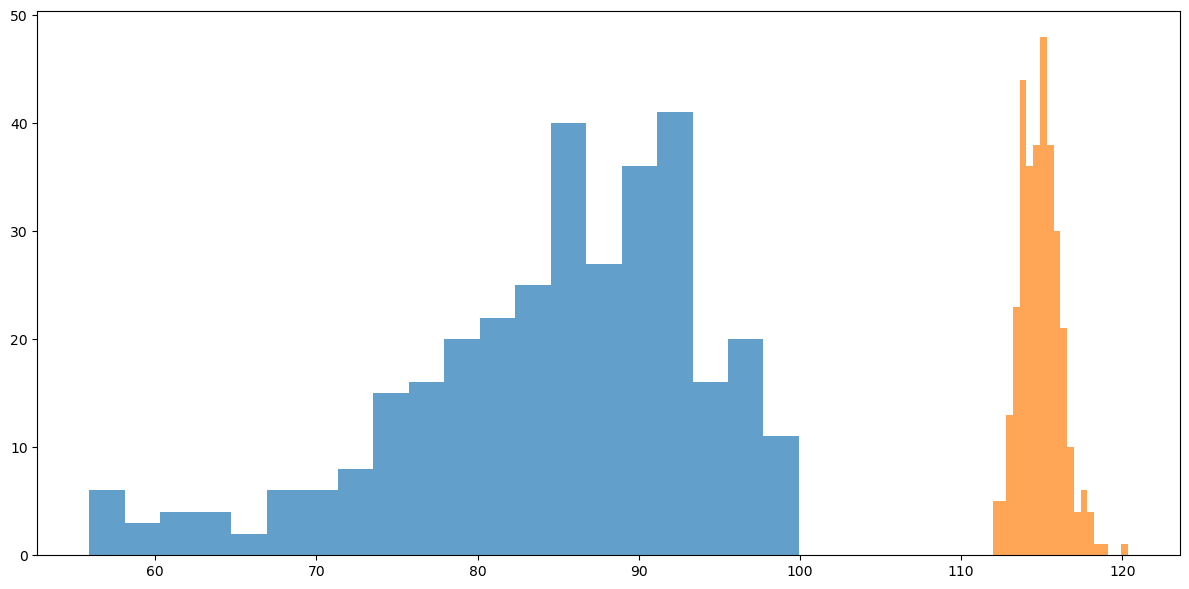

In [114]:
plt.figure(figsize=(12, 6))  # Adjust the figure size as desired

plt.hist(real_distances, bins=20, alpha=0.7, label='Real Images')
plt.hist(fake_distances, bins=20, alpha=0.7, label='Fake Images')

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()

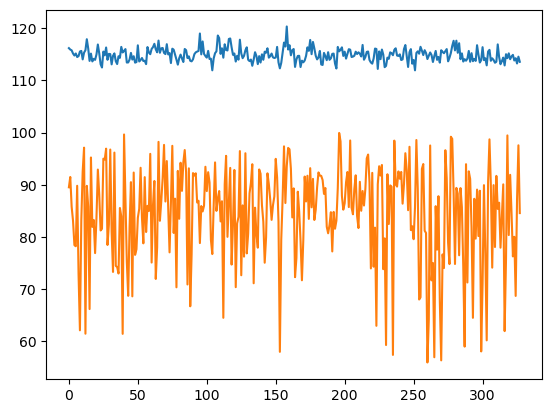

In [115]:
plt.plot(fake_distances)
plt.plot(real_distances)